In [84]:
import os
import numpy as np 
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [85]:
os.chdir('/kaggle/input/BloodPressureDataset')

# ECG Features

In [86]:
def detect_r_peaks_ecg(signal, sampling_rate, min_hr, threshold_coef=1):
    # Find peaks above the threshold
    threshold = np.mean(signal) + threshold_coef * np.std(signal)
    peaks = np.where(signal > threshold)[0]
    # Filter out peaks that are too close to each other
    min_distance = sampling_rate / min_hr
    peaks = [peaks[i] for i in range(1, len(peaks)) if peaks[i] - peaks[i - 1] > min_distance]
    return np.array(peaks)

In [87]:
def extract_ecg_features(signal, sampling_rate, min_hr=30, max_hr =220, threshold_coef=1):
    r_peaks = detect_r_peaks_ecg(signal, sampling_rate, min_hr, threshold_coef)

    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks)

    # Calculate heart rate
    heart_rate = min(max_hr, 60.0 / (np.mean(rr_intervals) / sampling_rate))
    rr_interval_variability = np.std(rr_intervals)/np.mean(rr_intervals)
    return heart_rate, rr_interval_variability

# PPG Features

In [88]:
def extract_ppg_features(signal, sampling_rate, min_hr, max_hr):
    num_samples = len(signal)
    fft_x = fft(signal)
    frequencies = fftfreq(num_samples, 1/sampling_rate)
    peaks, _ = find_peaks(np.abs(fft_x)[1:num_samples//2], distance=num_samples/fs)
    peak_index =  peaks[np.argsort(np.abs(fft_x[peaks]))[::-1][:3]]
    peak_frequencies = np.round(frequencies[peak_index],1)
    peak_frequency = [element for element in peak_frequencies if min_hr/60 <= element <= max_hr/60]
    if len(peak_frequency) > 0:
        heart_rate = 60 * float(min(peak_frequency))
    else:
        heart_rate = np.nan
    return heart_rate

# Processing Loop

In [89]:
fs = 125
heart_rates_ppg = []
heart_rates_ecg = []
rr_interval_variability = []

for ii in range(12):
    
    filename = 'part_' + str(ii + 1) + '.mat'
    mat_data = scipy.io.loadmat(filename)['p']
    
    for jj in range(1000):
        ecg_signal = mat_data[0][jj][1]
        ppg_signal = mat_data[0][jj][0]
        
        heart_rate_ppg = extract_ppg_features(ppg_signal, fs, min_hr=30, max_hr=220)
        heart_rate_ecg, rr_variability = extract_ecg_features(ecg_signal, fs, min_hr=30, max_hr=220, threshold_coef =1)

        heart_rates_ppg.append(heart_rate_ppg)
        heart_rates_ecg.append(heart_rate_ecg)
        rr_interval_variability.append(rr_variability)

# Heart Rate

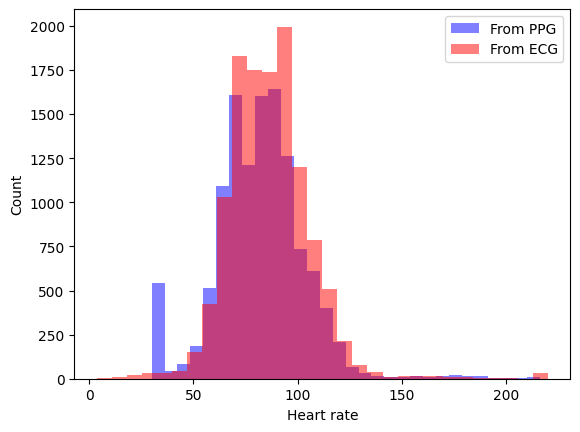

In [98]:
plt.hist(heart_rates_ppg, bins=30, alpha=0.5, color='blue', label='From PPG')
plt.hist(heart_rates_ecg, bins=30, alpha=0.5, color='red', label='From ECG')
plt.xlabel('Heart rate')
plt.ylabel('Count')
plt.legend()